# Project: Adversarial BayesFlow

# Experiment 2: MVN means and full covariance

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats
from functools import partial



sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

from abf_functions import *

FILEFORMAT = 'png'

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [3]:
D = 5

#########

class NormalInverseWishartPrior:
    def __init__(self, D, mu_0=0.0, lamda_0=1.0, Psi_0=None, nu_0=None):
        if Psi_0 is None:
            Psi_0 = np.eye(D)
        if nu_0 is None:
            nu_0 = D+1
        self.D = D,
        self.mu_0 = mu_0
        self.lamda_0 = lamda_0
        self.Psi_0 = Psi_0
        self.nu_0 = nu_0
        
        self.cov_prior = stats.invwishart(self.nu_0, self.Psi_0)
        
    def __call__(self, n_sim):
        cov = self.cov_prior.rvs(n_sim)
        tril_cov = tf.linalg.cholesky((1.0 / self.lamda_0) * cov)
        means = tfp.distributions.MultivariateNormalTriL(self.mu_0, tril_cov).sample()
        
        return np.array(means, dtype=np.float32), np.array(cov, dtype=np.float32)


def param_transform_full_cov(theta):
    means, cov = theta
    means = np.array(means)
    n_sim, D = means.shape
    cov = np.array(cov)
    cov = cov[np.tril(cov).nonzero()].reshape(n_sim, -1)
    return np.concatenate([means, cov], axis=1)


mu_0 = 0.0
lamda_0 = 5
Psi_0 = np.eye(D)
nu_0 = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0, lamda_0=lamda_0, Psi_0=Psi_0, nu_0=nu_0)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 64},
    'dense_s2_args': {'activation': 'relu', 'units': 64},
    'dense_s3_args': {'activation': 'relu', 'units': 64},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=(sum(range(1, D+1)) + D),  
                                   activation_out=None  # linear
)


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': sum(range(1, D+1)) + D,   # lower diagonal cov (1+2+...+D) and D means
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0005,
                      checkpoint_path='export_ckpt/mmd/full_cov_5D',
                      max_to_keep = 2
                     )

Networks loaded from export_ckpt/mmd/full_cov_5D/ckpt-100


In [4]:
# losses = trainer.train_rounds(epochs=10, rounds=10, sim_per_round=10000, batch_size=128, n_obs=100)

In [5]:
def param_list_to_mean_cov(theta, D):
    # setup
    n_sim = theta.shape[0]
    mean = theta[:, :D]
    cov_list = theta[:, D:]
    tril_idx1, tril_idx2 = np.tril_indices(D)
    cov = np.zeros((n_sim, D, D))
    
    # fill cov matrix
    for i in range(n_sim):
        # write from flattened array into in lower triangular matrix
        cov[i, tril_idx1, tril_idx2] = cov_list[i, :]
        
        # mirror lower triangular matrix to upper triangle
        cov[i] = cov[i] + cov[i].T - np.diag(np.diag(cov[i]))
    return mean, cov

def cov_to_corr(cov, std_devs_on_diagonal=True, epsilon=1e-6):
    corr = np.zeros_like(cov)
    n_sim = cov.shape[0]
    
    for i in range(n_sim):
        # extract 2D matrix
        Sigma = cov[i, :, :]
        
        # transform 2D cov matrix into corr matrix
        std_devs = np.sqrt(np.maximum(np.diag(Sigma), epsilon))
        Dinv = np.diag(1 / std_devs)
        corr[i] = Dinv @ Sigma @ Dinv
        
        # increase information by putting SDs on diagonal instead of 1's
        if std_devs_on_diagonal:
            np.fill_diagonal(corr[i], std_devs)
            
    return corr

def theta_cov_to_corr(theta, D):
    mean, cov = param_list_to_mean_cov(theta, D=D)
    corr = cov_to_corr(cov)
    theta_corr = param_transform_full_cov((mean, corr))
    return theta_corr

def true_vs_estimated_tril(theta_true, theta_est, param_names, D, dpi=300,
                      figsize=(20, 4), show=True, filename=None, font_size=12):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values.

    Parameters
    ----------
    theta_true: np.array
        Array of true parameters.
    theta_est: np.array
        Array of estimated parameters.
    param_names: list
        List of parameter names for plotting.
    D : int
        Number of dimensions of parameters.
    dpi: int, default:300
        Dots per inch (dpi) for the plot.
    figsize: tuple(int, int), default: (20,4)
        Figure size.
    show: boolean, default: True
        Controls if the plot will be shown
    filename: str, default: None
        Filename if plot shall be saved
    font_size: int, default: 12
        Font size

    """
    
    idx = 0

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Determine n_subplots dynamically
    n_row = D+1
    n_col = D

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
        
    # --- Plot true vs estimated posterior means on a single row --- #
    
    for i in range(n_row):
        for j in range(n_col):
            if j>(i-1) and i != 0:
                axarr[i, j].axis('off')
            else:
                # Plot analytic vs estimated
                axarr[i, j].scatter(theta_est[:, idx], theta_true[:, idx], color='black', alpha=0.4)

                # get axis limits and set equal x and y limits
                lower_lim = min(axarr[i, j].get_xlim()[0], axarr[i, j].get_ylim()[0])
                upper_lim = max(axarr[i, j].get_xlim()[1], axarr[i, j].get_ylim()[1])
                axarr[i, j].set_xlim((lower_lim, upper_lim))
                axarr[i, j].set_ylim((lower_lim, upper_lim))
                axarr[i, j].plot(axarr[i, j].get_xlim(), axarr[i, j].get_xlim(), '--', color='black')

                # Compute NRMSE
                rmse = np.sqrt(np.mean( (theta_est[:, idx] - theta_true[:, idx])**2 ))
                nrmse = rmse / (theta_true[:, idx].max() - theta_true[:, idx].min())
                axarr[i, j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                             horizontalalignment='left',
                             verticalalignment='center',
                             transform=axarr[i, j].transAxes,
                             size=10)

                # Compute R2
                #r2 = r2_score(theta_true[:, j], theta_est[:, j])
                #axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                #             horizontalalignment='left',
                #             verticalalignment='center',
                #             transform=axarr[j].transAxes, 
                #             size=10)

                if j == 0 and i == 0 or 0==0:
                    # Label plot
                    axarr[i, j].set_xlabel('Estimated')
                    axarr[i, j].set_ylabel('True')
                axarr[i, j].set_title(param_names[idx])
                axarr[i, j].spines['right'].set_visible(False)
                axarr[i, j].spines['top'].set_visible(False)
                
                idx += 1
    
    # Adjust spaces
    f.tight_layout()
    
    if filename is not None:
        f.savefig(filename)

    if show:
        plt.show()



### Analytic posterior

In [6]:
def analytic_joint_posterior_normal_inverse_wishart(X, mu_0, lamda_0, Psi_0, nu_0):
    n_sim, n_obs, D = X.shape
    mu_n = [None] * n_sim
    lamda_n = [None] * n_sim
    Psi_n = [None] * n_sim
    nu_n = [None] * n_sim
    
    for i in range(n_sim):
        x = X[i, :, :]
        x_bar = np.mean(x, axis=0)
        C = np.dot((x-x_bar).T, x-x_bar)
        
        mu_n[i] = (lamda_0 * mu_0 + n_obs*x_bar) / (lamda_0 + n_obs)
        lamda_n[i] = lamda_0 + n_obs
        nu_n[i] = nu_0 + n_obs
        Psi_n[i] = Psi_0 + C + ((lamda_0*n_obs)/(lamda_0+n_obs)) * np.dot(x_bar-mu_0, (x_bar-mu_0).T)
        
    return mu_n, lamda_n, Psi_n, nu_n


def marginal_posterior_normal_inverse_wishart(mu_n, lamda_n, Psi_n, nu_n):
    D = mu_n[0].shape[0]
    n_sim = len(mu_n)
    
    marginal_mu_distributions = [None] * n_sim
    marginal_Sigma_distributions = [None] * n_sim

    for i in range(n_sim):
        # mu_p
        marginal_mu_distributions[i] = stats.multivariate_t(
            loc=mu_n[i], 
            shape=np.linalg.inv(Psi_n[i]) / (lamda_n[i]*(nu_n[i] - D + 1)), 
            df=nu_n[i] - D + 1
        )
        
        # Sigma_p
        marginal_Sigma_distributions[i] = stats.invwishart(nu_n[i], Psi_n[i])
    
    return marginal_mu_distributions, marginal_Sigma_distributions

In [7]:
def adversarial_diagnostics_mvn_full_cov(trainer, theta, x, mu_0=0.0, lamda_0=5, Psi_0=np.eye(5), nu_0=10, 
                                         print_plots=False, filename=None):
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)

    param_means = theta_cov_to_corr(param_means, D=D)

    mu_n, lamda_n, Psi_n, nu_n = analytic_joint_posterior_normal_inverse_wishart(x, mu_0, lamda_0, Psi_0, nu_0)

    marginal_mu_p, marginal_Sigma_p = marginal_posterior_normal_inverse_wishart(mu_n, lamda_n, Psi_n, nu_n)

    mu_p_means = np.array([dist.loc for dist in marginal_mu_p])
    Sigma_p_covs = np.array([marginal_Sigma_p[i].scale / (nu_n[i]-D-1) for i in range(len(marginal_Sigma_p))])

    theta_analytical_posterior = param_transform_full_cov((mu_p_means, Sigma_p_covs))
    theta_analytical_posterior = theta_cov_to_corr(theta_analytical_posterior, D=D)

    param_names = [r'$\mu_%i$'%i for i in range(1, D+1)] + \
    [r'$\sigma_%i$'%(i+1) if i==j else r'cor$_{%i%i}$'%(i+1, j+1) for (i, j) in zip(*np.tril_indices(D))]

    # analytical posterior
    true_vs_estimated_tril(theta_analytical_posterior, param_means, param_names, D, figsize=(20,20), filename=f"{filename}_true_analytic.{FILEFORMAT}")

        
    
    if print_plots:
        s = np.array(trainer.network.summary_net(x))
        sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")
        if filename is not None:
            plt.savefig(f"{filename}_summary_response.{FILEFORMAT}")

### (A0) Baseline

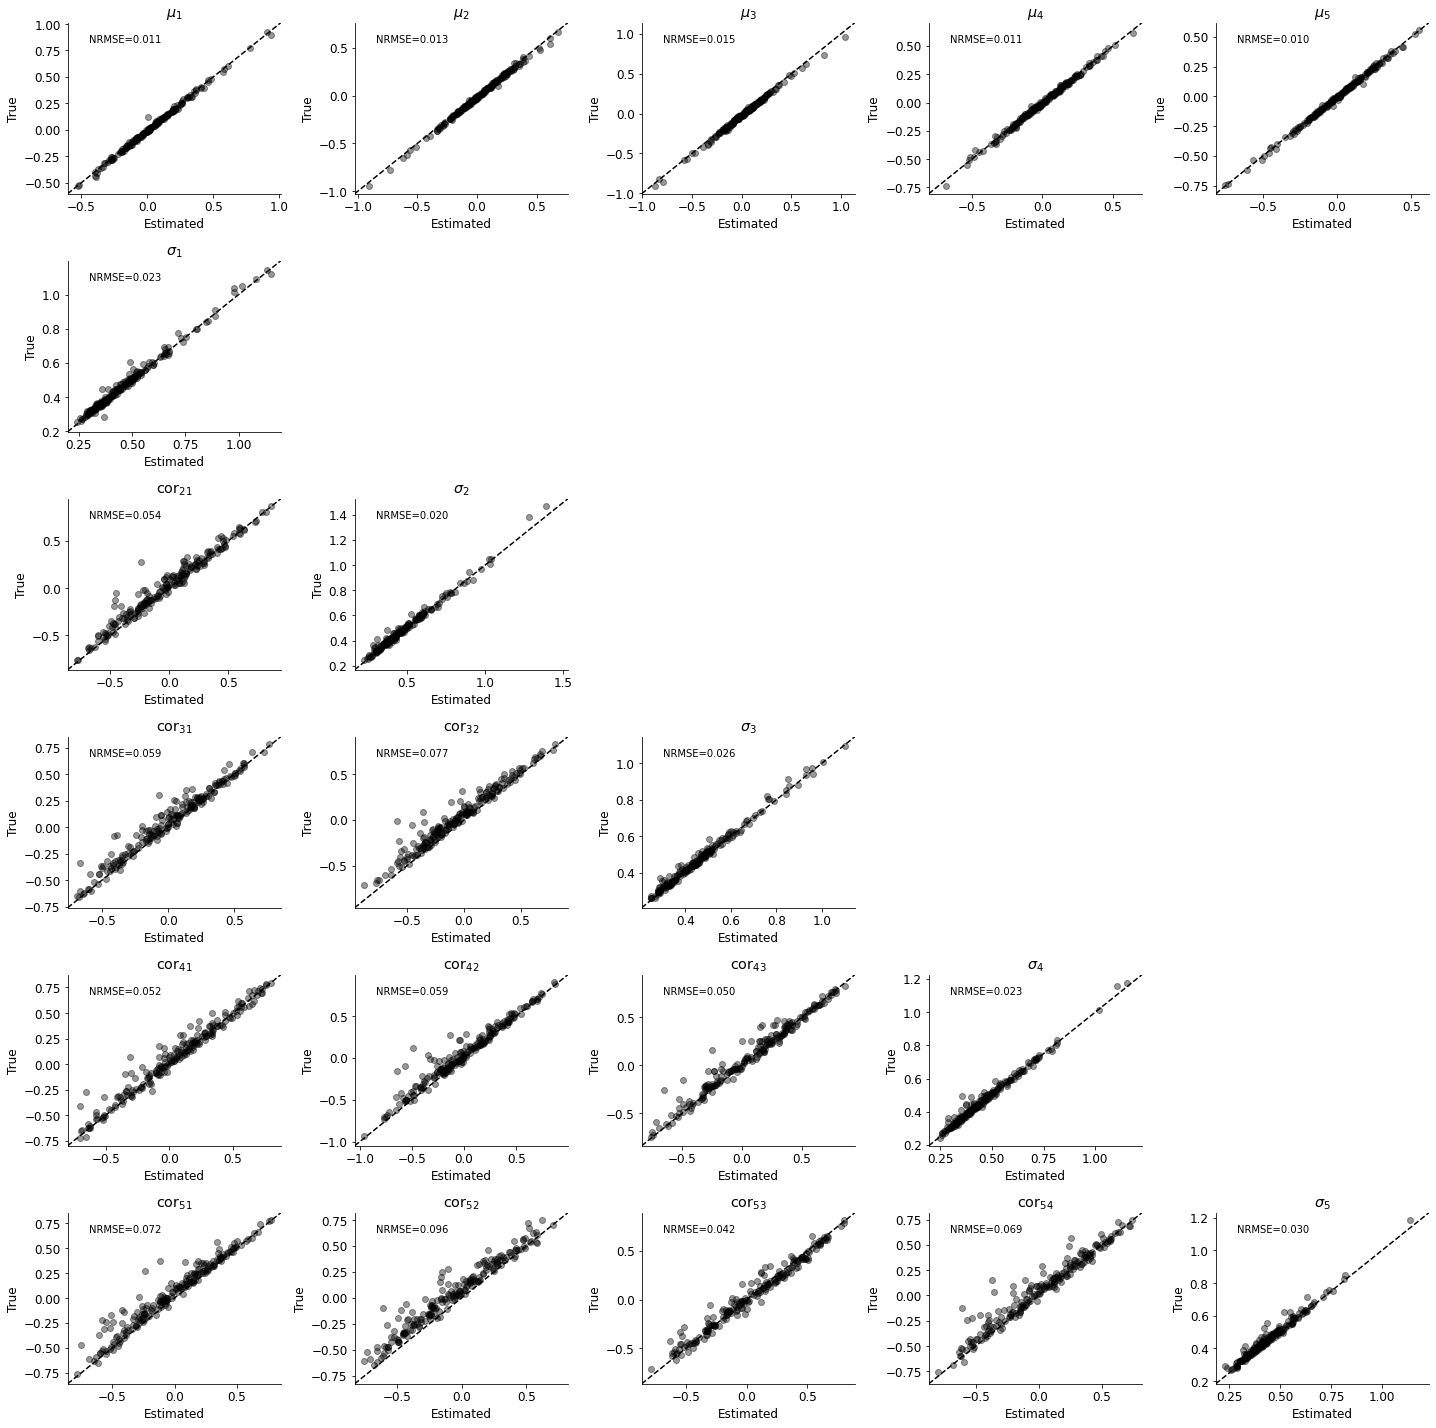

In [8]:
mu_0o = 0.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)


adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_cov_A0")

### (A1) - a

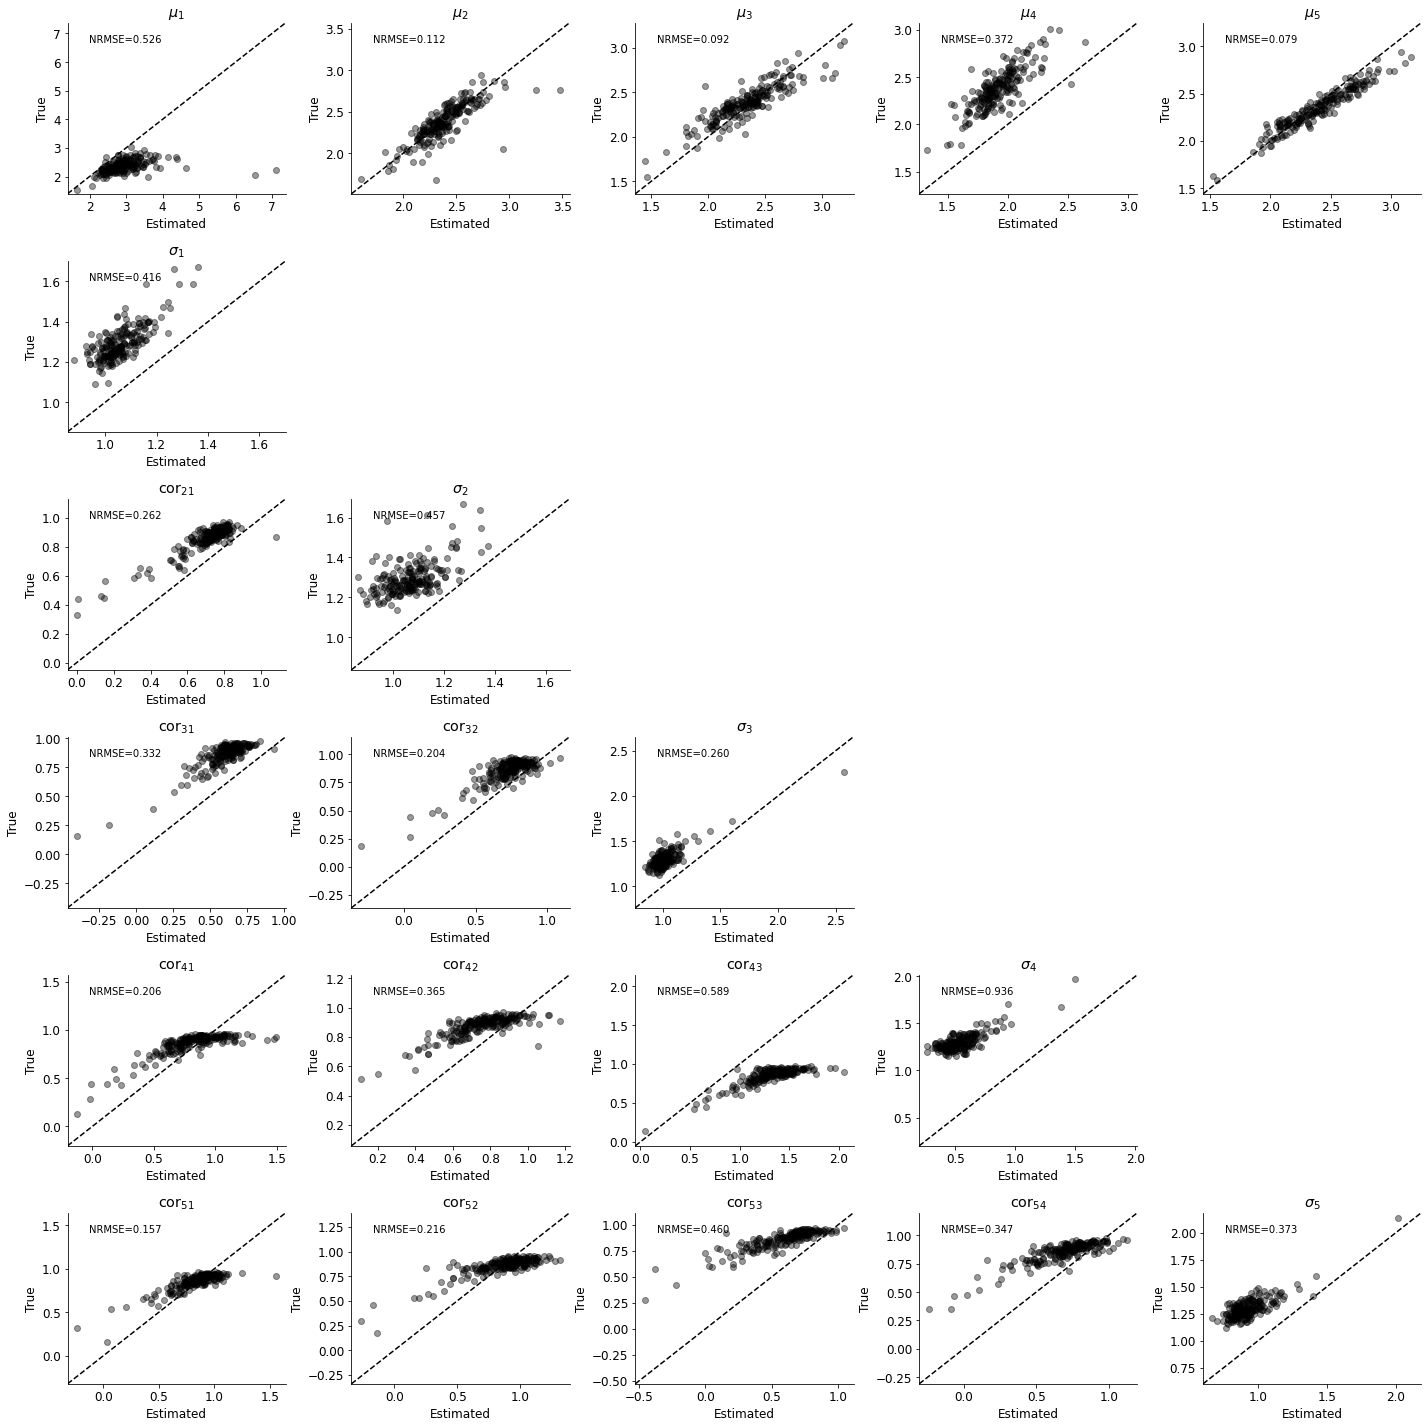

In [9]:
mu_0o = 2.5
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)


adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_cov_A1a")

### (A1) - b

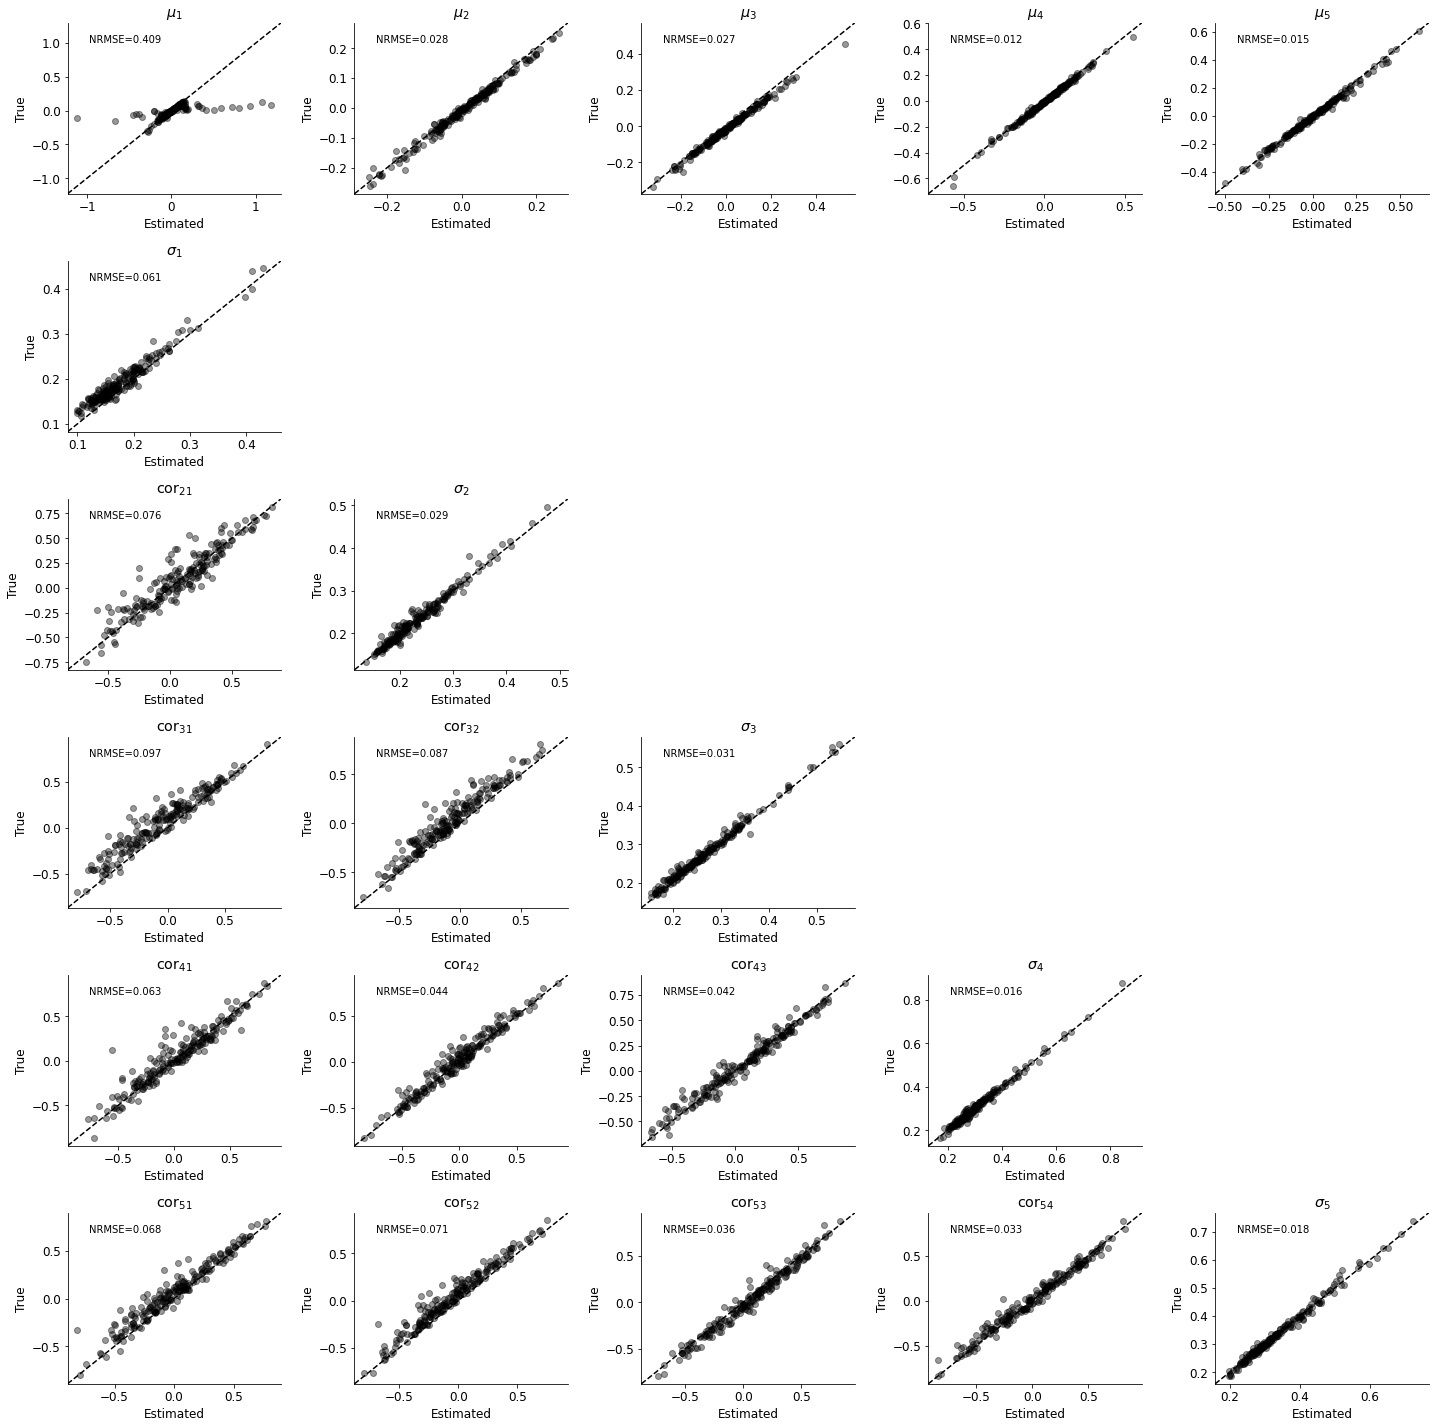

In [10]:
mu_0o = 0.0
lamda_0o = 5
Psi_0o = np.diag([0.1, 0.2, 0.3, 0.4, 0.5])
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)


adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_cov_A1b")

### (A2)

$\boldsymbol{x}^{(i)}\sim t_2(\boldsymbol{\mu}^{(i)}, \boldsymbol{\Sigma}^{(i)})$

In [11]:
class MultivariateTSimulatorFullCov:
    def __init__(self, df=2):
        self.df = df

    def simulate_data(self, mean, cov, n_obs):
        x = stats.multivariate_t(loc=mean, shape=cov, df=self.df).rvs(n_obs)
        return x

    def generate_multiple_datasets(self, p_samples, n_obs):
        mean, cov = p_samples
        n_sim = mean.shape[0]
        theta_dim = mean.shape[1]
        sim_data = np.zeros((n_sim, n_obs, theta_dim))

        for bi in range(n_sim):
            sim_data[bi] = self.simulate_data(mean[bi], cov[bi], n_obs)
        return sim_data.astype(np.float32)

    def __call__(self, p_samples, n_obs):
        return self.generate_multiple_datasets(p_samples, n_obs)

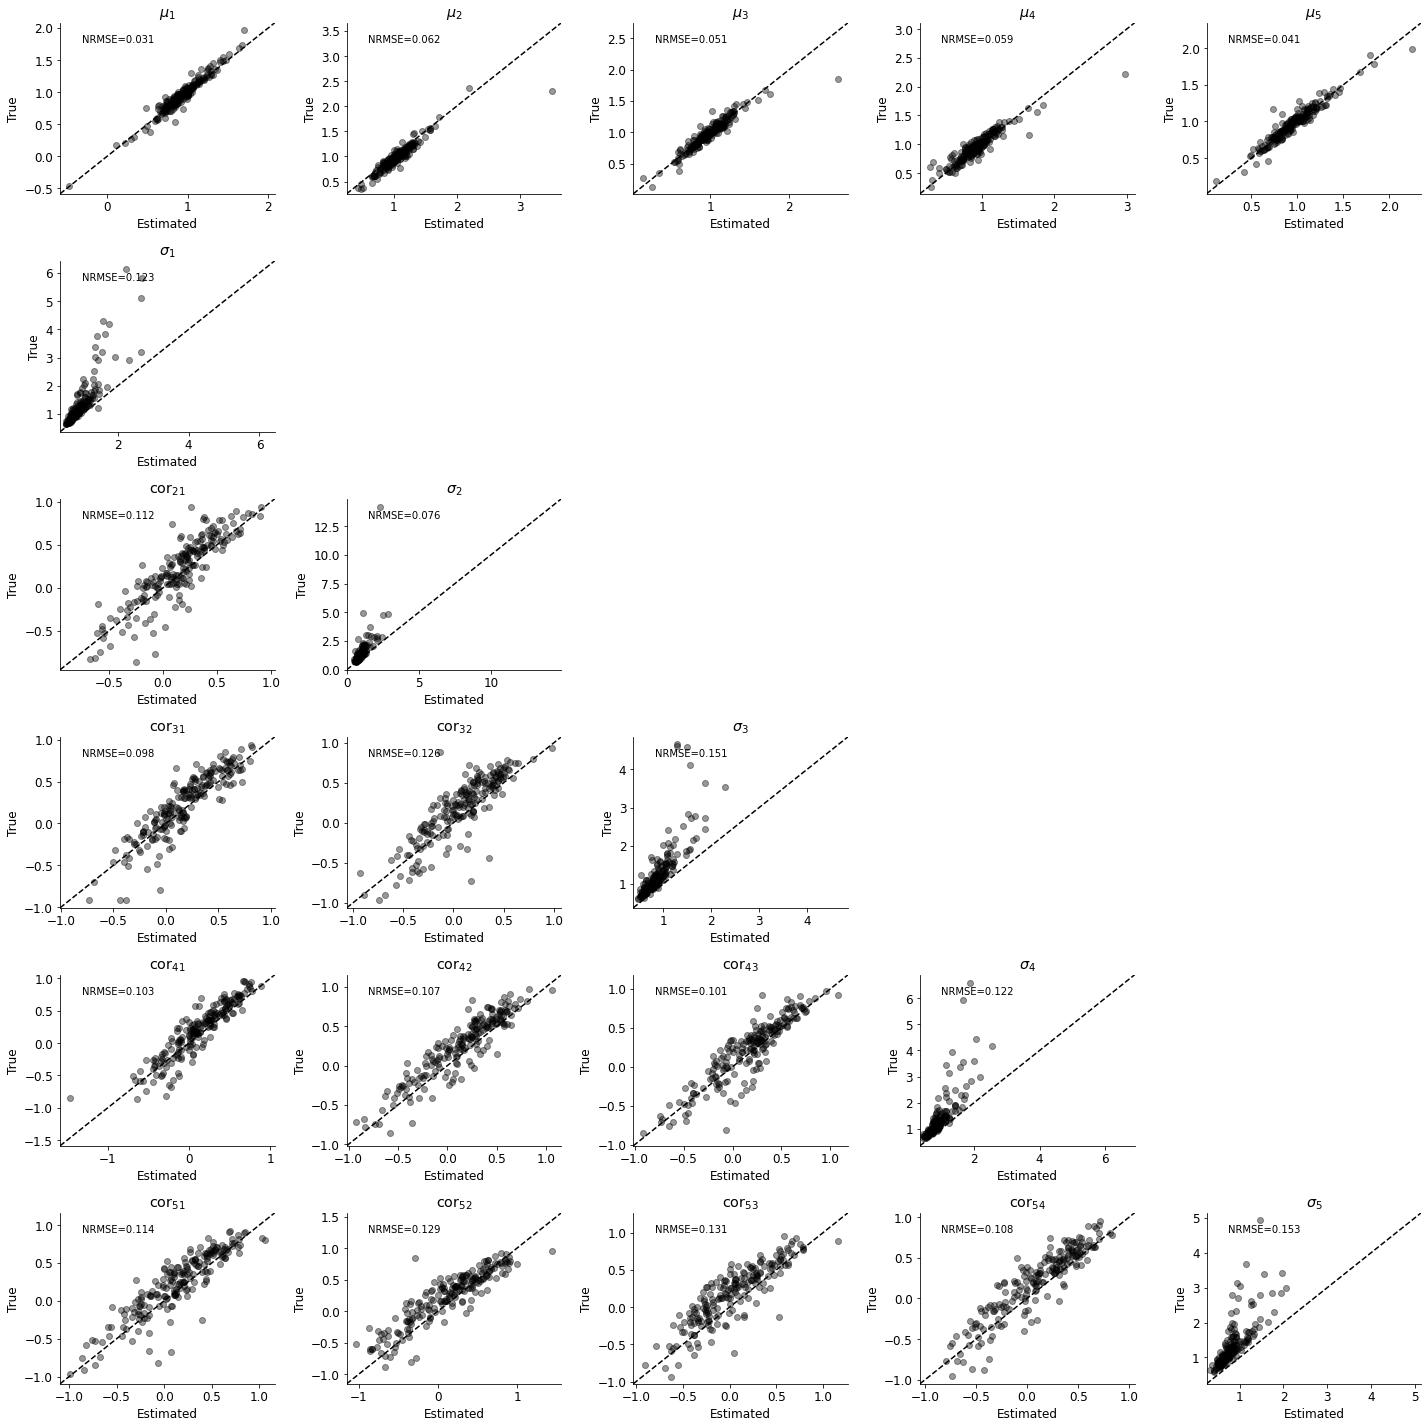

In [12]:
mu_0o = 1.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = MultivariateTSimulatorFullCov(df=2)
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)


adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_cov_A2")

# todo: investigate if the EST_VS_ANALYTICAL outliers are also outliers in summary space

## (A3) Contamination

In [13]:
def normalize(x):
    return x

"""
    n_sim, n_obs, data_dim = x.shape
    s = np.std(x, axis=1)
    s_reshaped = s.reshape(n_sim, 1, data_dim).repeat(n_obs, axis=1)
    x_normalized = np.divide(x, s_reshaped)
    return x_normalized
    """

'\n    n_sim, n_obs, data_dim = x.shape\n    s = np.std(x, axis=1)\n    s_reshaped = s.reshape(n_sim, 1, data_dim).repeat(n_obs, axis=1)\n    x_normalized = np.divide(x, s_reshaped)\n    return x_normalized\n    '

### (A3) - a

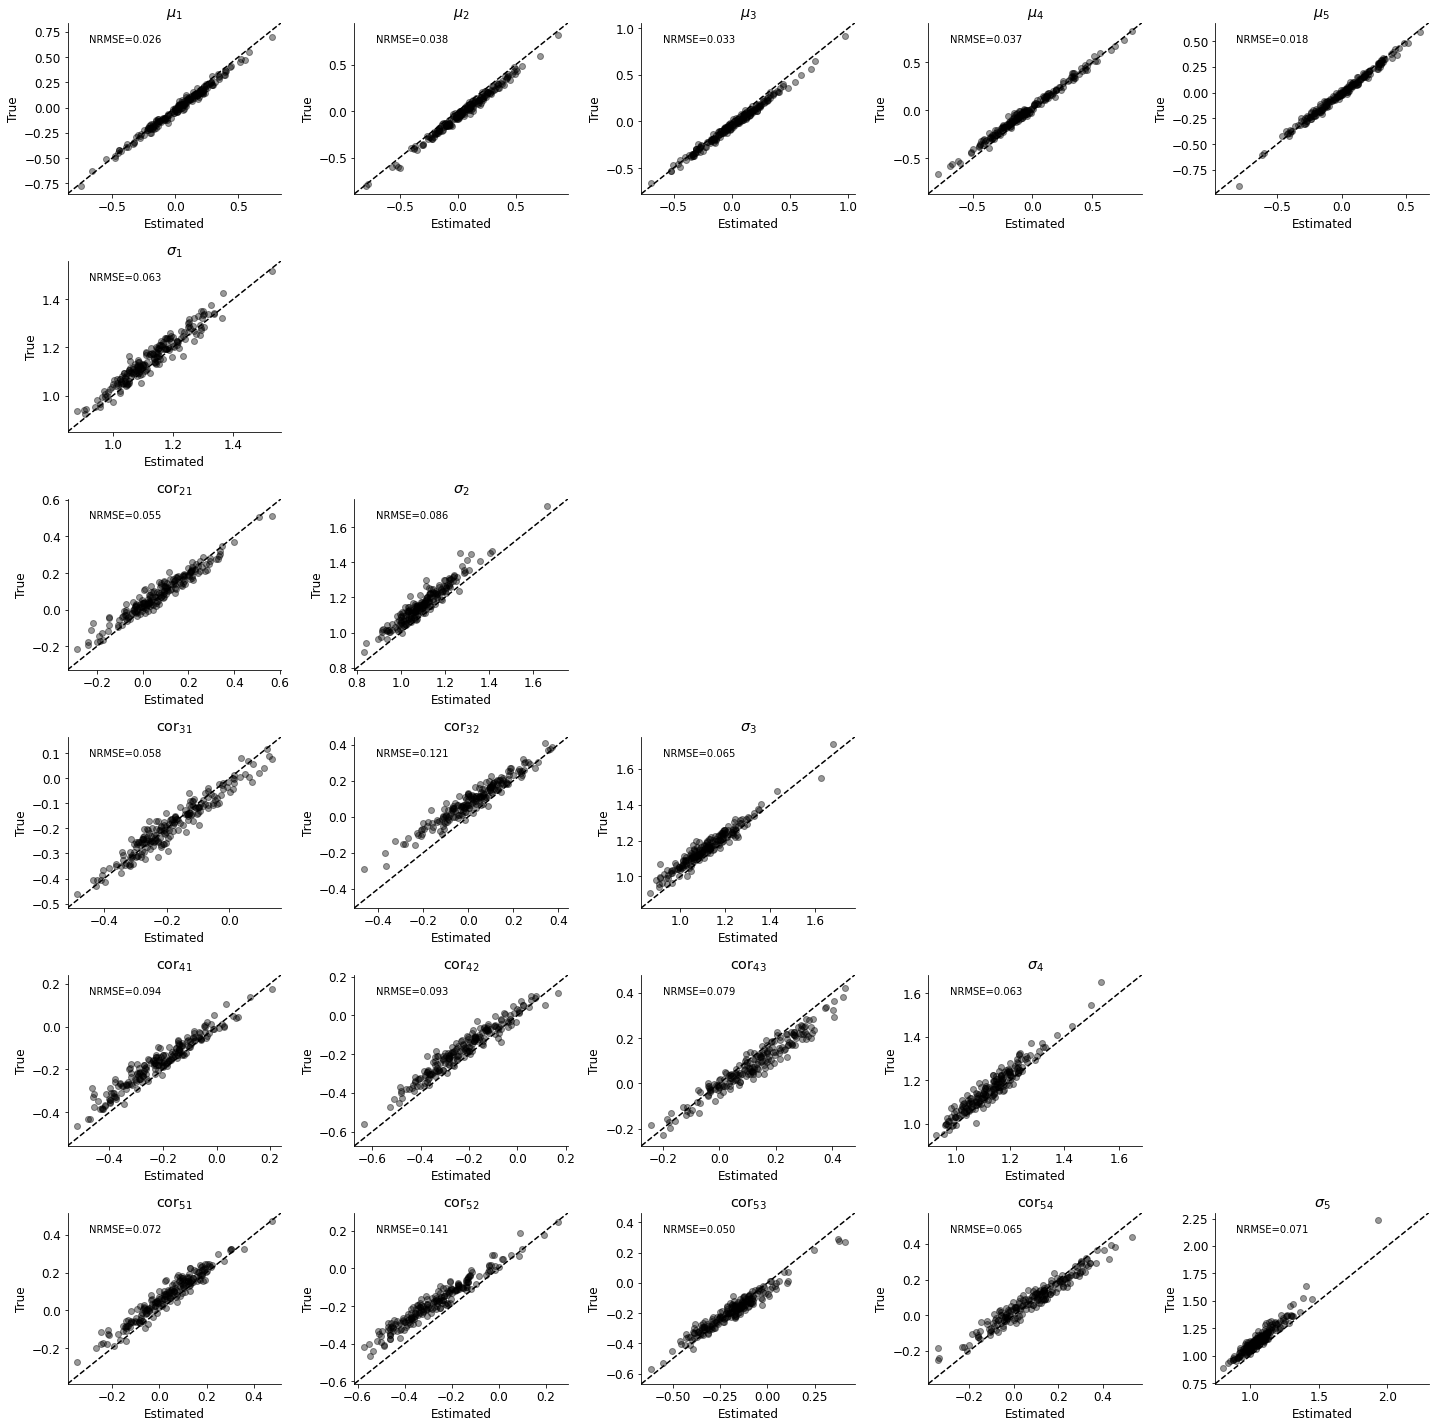

In [14]:
import colorednoise as cn

mu_0o = 0.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)

lamda = 1.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)

x_tilde = normalize(x + lamda * xi)

adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x_tilde, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_cov_A3a")



### (A3) - b

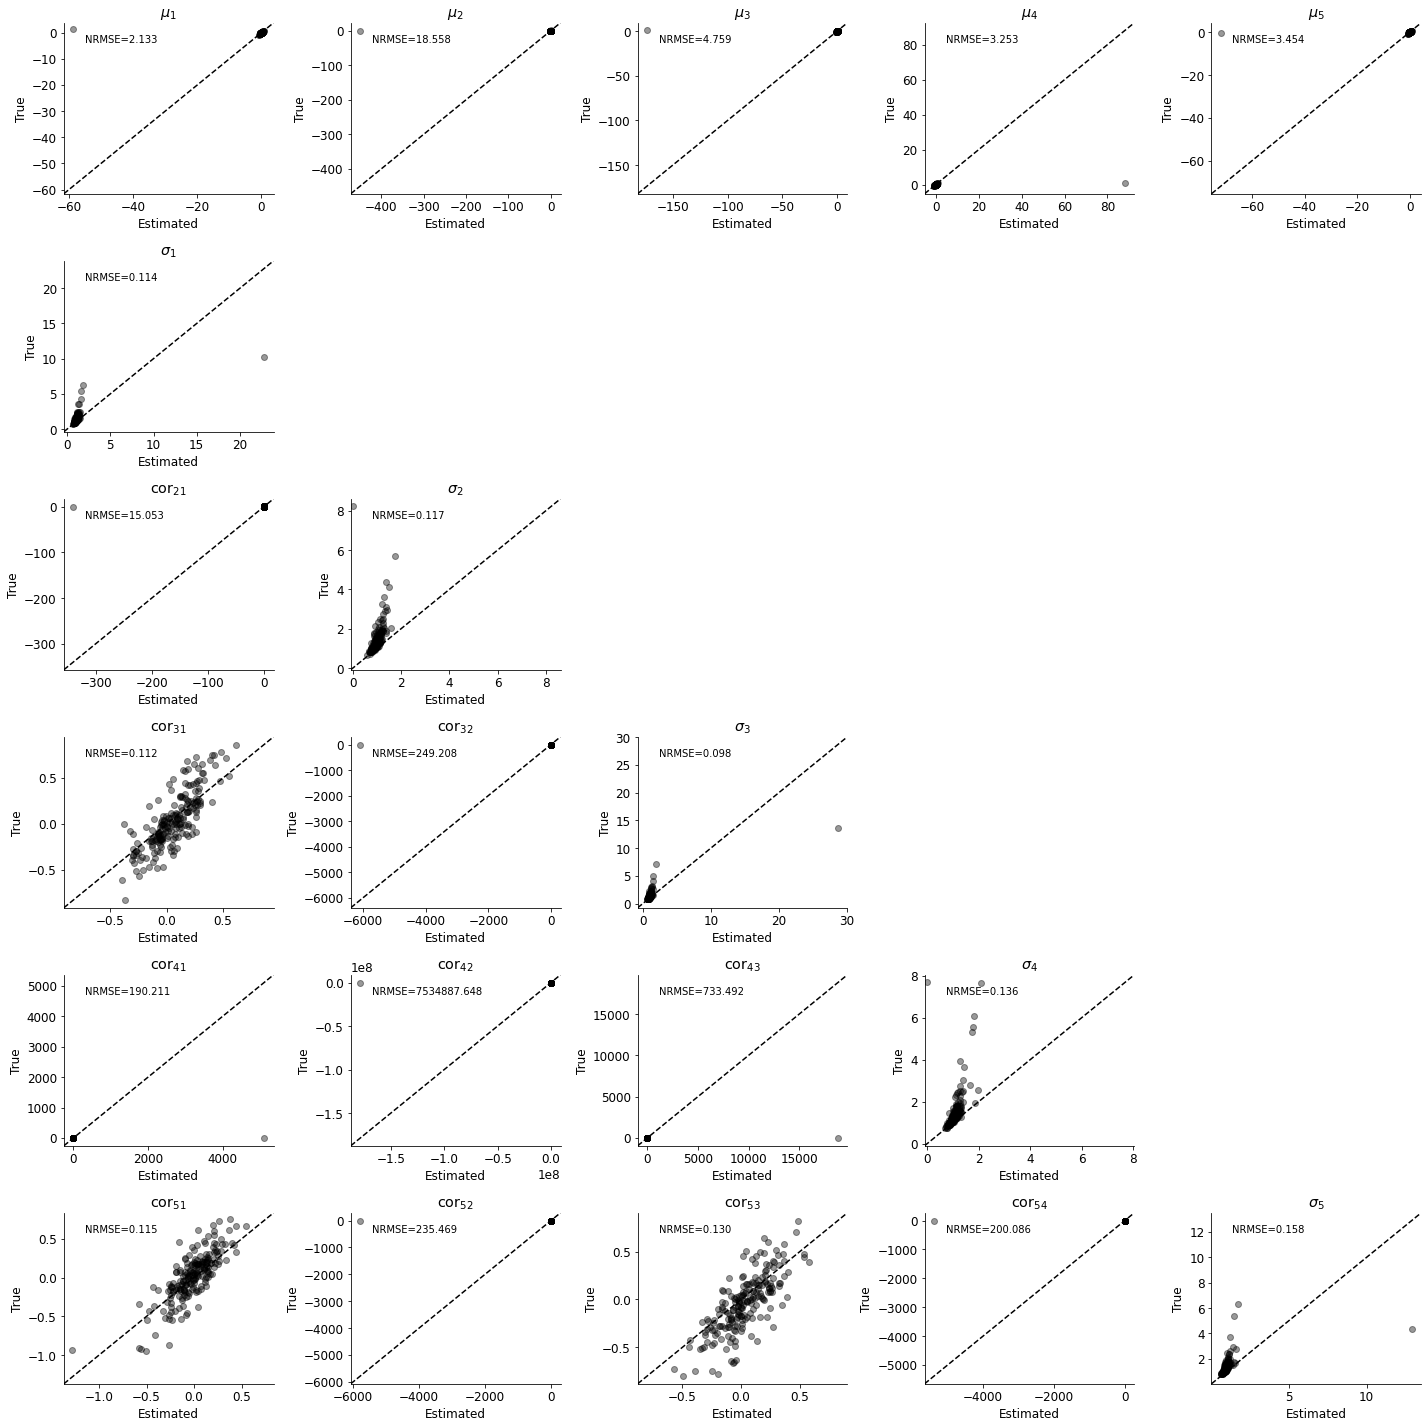

In [15]:
mu_0o = 0.0
lamda_0o = 5
Psi_0o = np.eye(D)
nu_0o = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

theta, x = generative_model(200, 100)

n_sim, n_obs, data_dim = x.shape


lamda = 0.5
xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
xi_simulator = MultivariateTSimulator(df=2)
xi = xi_simulator(xi_theta, n_obs)

x_tilde = normalize(x + lamda * xi)

adversarial_diagnostics_mvn_full_cov(trainer, theta=theta, x=x_tilde, 
                                     #print_plots=True,
                                    filename="plots/abf_mvn_full_cov_A3b")

# Summary space: MD and MMD plots

In [16]:
def mahalanobis_distance_2D_1D(data, ref, cov):
    n = data.shape[0]
    mahalanobis_distances = [scipy.spatial.distance.mahalanobis(data[i], ref, cov) for i in range(n)]
    return np.array(mahalanobis_distances)

def MD_analysis(x_star, X_o):
    z_psi = np.array(trainer.network.summary_net(x_star))

    mu_z_psi = np.mean(z_psi, axis=0)
    cov_z_psi = np.cov(z_psi, rowvar=False)

    MD_mean, MD_std = np.zeros(len(X_o)), np.zeros(len(X_o))

    for i, x_o in enumerate(X_o):
        s_o = np.array(trainer.network.summary_net(x_o))
        m = mahalanobis_distance_2D_1D(s_o, mu_z_psi, cov_z_psi)
        MD_mean[i] = np.mean(m)
        MD_std[i] = np.std(m)

    return MD_mean, MD_std

def MMD_analysis(x_star, X_o):
    z_psi = np.array(trainer.network.summary_net(x_star))
    MMD = np.zeros(len(X_o))

    for i, x_o in enumerate(X_o):
        s_o = np.array(trainer.network.summary_net(x_o))
        MMD[i] = float(maximum_mean_discrepancy(s_o, z_psi))

    return MMD

In [17]:
def plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    plt.figure(figsize=(12, 6))
    
    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)
        plt.axhline(y=MD_mean[baseline_idx]+MD_std[baseline_idx], color="gray", ls="--", alpha=.40)
        plt.axhline(y=MD_mean[baseline_idx]-MD_std[baseline_idx], color="gray", ls="--", alpha=.40)
        plt.axhline(y=MD_mean[baseline_idx], ls="--", color="gray")

    plt.errorbar(alphas, MD_mean, yerr=MD_std, marker='s', ecolor='lightgray')

    plt.xlabel(x_label)
    if xticks is not None:
        plt.xticks(xticks)
    plt.ylabel("Mahalanobis Distance")
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f"plots/abf_mvn_full_cov_md_summary_{task_name}.{FILEFORMAT}")
    plt.show()
    
    
def plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    plt.figure(figsize=(12, 6))
    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)
        plt.axhline(y=MMD[baseline_idx], color="gray", ls="--")

    plt.plot(alphas, MMD, marker='s')

    plt.xlabel(x_label)
    if xticks is not None:
        plt.xticks(xticks)
    plt.ylabel("MMD")
    if ylim is not None:
        plt.ylim(ylim)
        plt.savefig(f"plots/abf_mvn_full_cov_mmd_summary_{task_name}.{FILEFORMAT}")
        plt.show()


In [18]:
def plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)

    color = 'tab:brown'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Mahalanobis Distance', color=color)
    if baseline_param is not None:
        plt.axhline(y=MD_mean[baseline_idx]+MD_std[baseline_idx], color=color, ls="--", alpha=.10)
        plt.axhline(y=MD_mean[baseline_idx]-MD_std[baseline_idx], color=color, ls="--", alpha=.10)
        plt.axhline(y=MD_mean[baseline_idx], ls="--", color=color, alpha=0.30)
        plt.axvline(x=baseline_param, ls="--", color="green", alpha=0.30)

    ax1.errorbar(alphas, MD_mean, yerr=MD_std, marker='s', ecolor='lightgray', color=color)
    
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Maximum Mean Discrepancy', color=color)  # we already handled the x-label with ax1
    if baseline_param is not None:
        plt.axhline(y=MMD[baseline_idx], color=color, alpha=0.30, ls="--")
    ax2.plot(alphas, MMD, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    if ylim is not None:
        ax1.set_ylim(ylim)
        ax2.set_ylim(ylim)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(f"plots/abf_mvn_full_cov_md_mmd_summary_{task_name}.{FILEFORMAT}")
    plt.show()

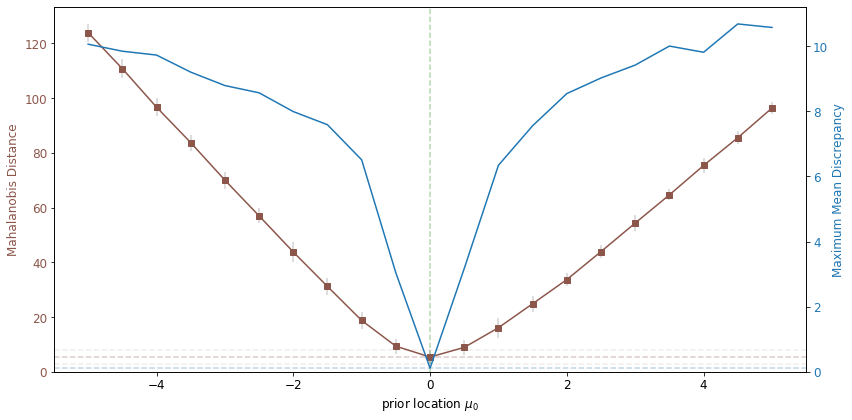

In [19]:
task_name = "A1a"
x_label = r"prior location $\mu_0$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.linspace(-5, 5, num=21)

for alpha in alphas:
    mu_0o = alpha
    lamda_0o = 5
    Psi_0o = np.eye(D)
    nu_0o = 10
    prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
    simulator = GaussianMeanCovSimulator()
    generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=0.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=0.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=0.0)

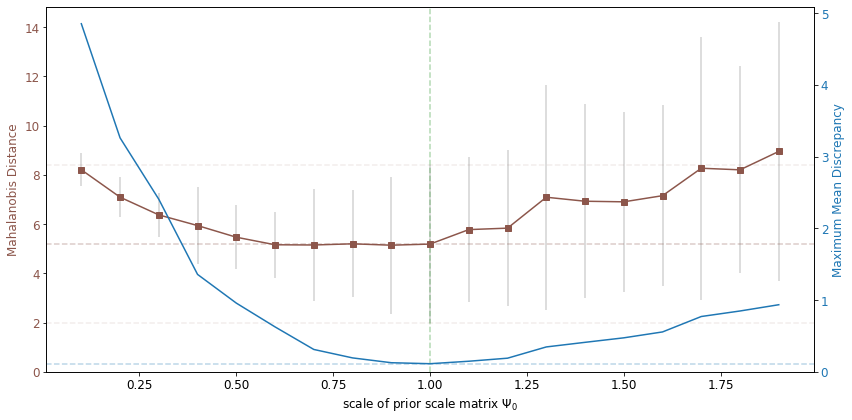

In [20]:
task_name = "A1b"
x_label = r"scale of prior scale matrix $\Psi_0$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.1, 2.0, step=0.1)

for alpha in alphas:
    mu_0o = 0.0
    lamda_0o = 5
    Psi_0o = alpha*np.eye(D)
    nu_0o = 10
    prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
    simulator = GaussianMeanCovSimulator()
    generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=1.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=1.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=1.0)

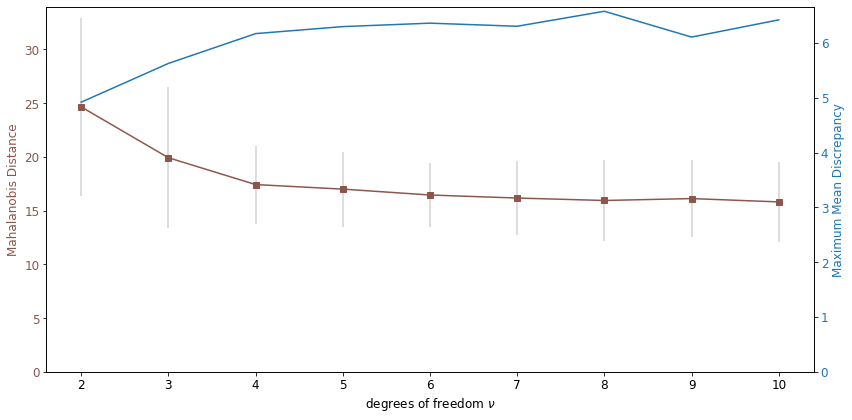

In [21]:
task_name = "A2"
x_label = r"degrees of freedom $\nu$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(2, 11, step=1)

for alpha in alphas:
    mu_0o = 1.0
    lamda_0o = 5
    Psi_0o = np.eye(D)
    nu_0o = 10
    prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
    simulator = MultivariateTSimulatorFullCov(df=int(alpha))
    generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

    theta, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=None)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=None)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=None)

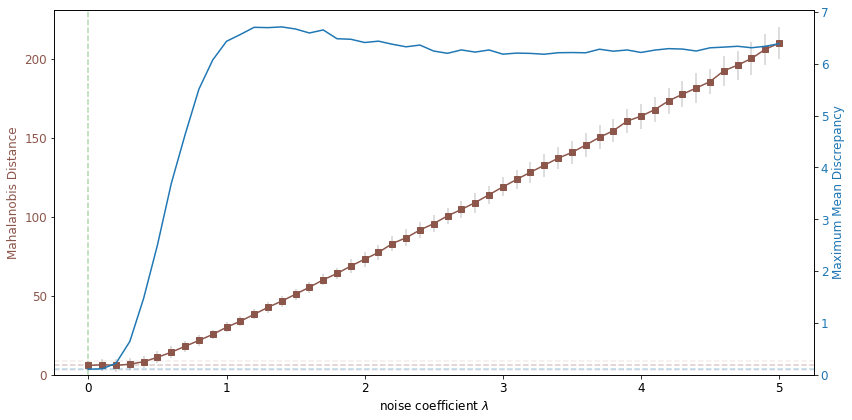

In [22]:
task_name = "A3a"
x_label = r"noise coefficient $\lambda$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.0, 5.1, step=0.1)

for alpha in alphas:
    mu_0o = 0.0
    lamda_0o = 5
    Psi_0o = np.eye(D)
    nu_0o = 10
    prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
    simulator = GaussianMeanCovSimulator()
    generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)
    theta, x_star = generative_model(200, 100)

    lamda = alpha  # contribution of contamination xi 

    xi = cn.powerlaw_psd_gaussian(exponent=1, size=x_star.shape)

    x_o = normalize(x_star + lamda * xi)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=0.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=0.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=0.0)

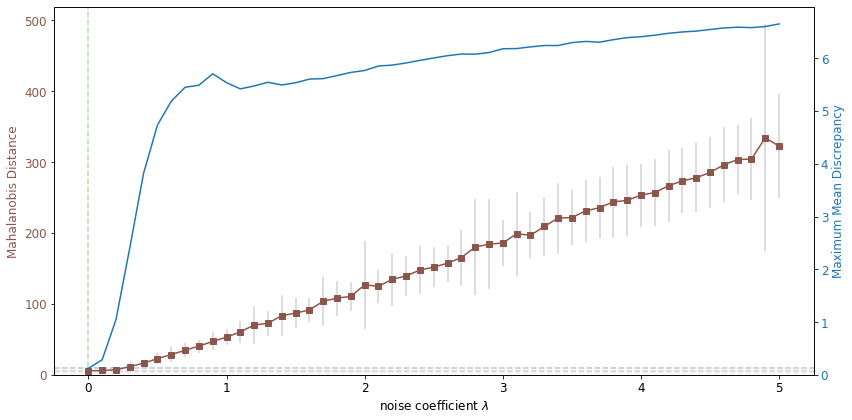

In [23]:
task_name = "A3b"
x_label = r"noise coefficient $\lambda$"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.arange(0.0, 5.1, step=0.1)

for alpha in alphas:
    mu_0o = 0.0
    lamda_0o = 5
    Psi_0o = np.eye(D)
    nu_0o = 10
    prior = NormalInverseWishartPrior(D=D, mu_0=mu_0o, lamda_0=lamda_0o, Psi_0=Psi_0o, nu_0=nu_0o)
    simulator = GaussianMeanCovSimulator()
    generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)
    theta, x_star = generative_model(200, 100)

    n_sim, n_obs, data_dim = x_star.shape


    lamda = alpha
    xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
    xi_simulator = MultivariateTSimulator(df=2)
    xi = xi_simulator(xi_theta, n_obs)

    x_o = normalize(x_star + lamda * xi)
    X_o.append(x_o)
    
MD_mean, MD_std = MD_analysis(x, X_o)
MMD = MMD_analysis(x, X_o)

#plot_mvn_MD(MD_mean, MD_std, alphas, task_name, x_label, baseline_param=0.0)
#plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param=0.0)
plot_mvn_MD_MMD(MD_mean, MD_std, MMD, alphas, task_name, x_label, baseline_param=0.0)